## The idea
- get a baseline performance using an analytical model of solar radiation & the metadata for each site

In [77]:
import pandas as pd
import numpy as np
from utils.model_utils import wmape
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
metadata = pd.read_csv('/Users/carterdemars/Desktop/pv_data/pv_metadata.csv')
metadata.index = metadata['system_id']
metadata.drop('Unnamed: 0', inplace=True, axis=1)

In [3]:
metadata.head()

,name,system_DC_capacity_W,address,num_panels,panel_capacity_W_each,panel_brand,num_inverters,inverter_capacity_W,inverter_brand,orientation,...,shade,install_date,latitude,longitude,status_interval_minutes,secondary_num_panels,secondary_panel_capacity_W_each,secondary_orientation,secondary_array_tilt_degrees,system_id
system_id,,,,,,,,,,,,,,,,,,,,,
24000,Pergola Fotovoltaica,9165,NaN,39,235,LG,1,10000,Power One PVI 10.0 OUTD-S,SE,...,No,2011-02-28,36.715286,15.091528,5,0,0,NaN,NaN,24000
48316,Saiazza,14000,96018.0,70,200,Deluxe,1,12500,Aurora,S,...,No,NaN,36.718600,15.090700,5,0,0,NaN,NaN,48316
41556,Tetto Fotovoltaico Saiazza,14000,96018.0,70,200,Deluxe,1,12500,Aurora,S,...,No,NaN,36.718600,15.090700,5,0,0,NaN,NaN,41556
24001,Scalecci,13230,96017.0,63,210,Centrosolar,1,12500,Power One PVI 12.5 OUTD FS,SE,...,No,2013-02-25,36.734759,15.098036,5,0,0,NaN,NaN,24001
24760,Marzamemi-FV,2990,96017.0,13,230,LG 230W,1,3000,Power One Aurora PVI 3.0,SW,...,Medium,2011-04-28,36.747195,15.108724,5,0,0,NaN,NaN,24760


We can take the PV sites with the most data for this experiment

In [4]:
pv = pd.read_csv('/Users/carterdemars/Desktop/pv_data/topten.csv')

In [5]:
pv.drop(['Unnamed: 0'], inplace=True, axis=1)

In [86]:
pv.shape

(1664700, 19)

In [7]:
categorical_names = ['system_id', 'panel_brand', 'orientation', 'shade']
categorical_locs = [pv.columns.get_loc(name) for name in categorical_names]
for feature in categorical_names:
 pv[feature] = pd.Series(pv[feature], dtype="category")

In [80]:
from lightgbm import LGBMRegressor

# try tuning these with optuna
opt_lgbm_params = {
 'subsample_freq': 1,
 'subsample': 1,
 'num_leaves': 30,
 'n_estimators': 100,
 'min_split_gain': 0.0001,
 'min_child_weight': 0,
 'min_child_samples': 20,
 'max_depth': 10,
 'learning_rate': 0.04,
 'colsample_bytree': 0.5,
 'colsample_bynode': 0.65,
 'categorical_feature': categorical_locs,
}

In [81]:
mdl = LGBMRegressor(**opt_lgbm_params)

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

X = pv.drop(['instantaneous_power_W', 'timestamp', 'azimuth'], axis=1)
#y = pv['instantaneous_power_W'].astype(float).apply(lambda x: np.maximum(x, 0))

X_train, X_test = X[X['year'] < 2020], X[X['year'] >= 2020]
y_train = pv[pv['year'] < 2020]['instantaneous_power_W'].astype(float).apply(lambda x: np.maximum(x, 0))
y_test = pv[pv['year'] >= 2020]['instantaneous_power_W'].astype(float).apply(lambda x: np.maximum(x, 0))
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
mdl.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


LGBMRegressor(categorical_feature=[0, 4, 5, 8], colsample_bynode=0.65,
              colsample_bytree=0.5, learning_rate=0.04, max_depth=10,
              min_child_weight=0, min_split_gain=0.0001, num_leaves=30,
              subsample=1, subsample_freq=1)

In [83]:
wmape(y_test, mdl.predict(X_test))

34.29218250256424

In [84]:
mdl.score(X_test, y_test)

0.8065075108502072

In [85]:
mdl.score(X_train, y_train)

0.8018419099462624

In [14]:
pv['system_id'].unique()

[11080, 11182, 17658, 17888, 20294, 20542, 23541, 28965, 28967, 32779]
Categories (10, int64): [11080, 11182, 17658, 17888, ..., 23541, 28965, 28967, 32779]

In [75]:
raw, post_process = [], []
for system in pv['system_id'].unique():
 Xtest1 = X_test[X_test['system_id'] == system]
 ytest1 = y_test.loc[Xtest1.index]
 Xtest1.index = pv[(pv['year'] >= 2020) & (pv['system_id'] == system)]['timestamp']
 ytest1.index = Xtest1.index
 pred1 = mdl.predict(Xtest1)
 raw.append(wmape(ytest1, pred1))
 pred1[pred1 < 0] = 0
 post_process.append(wmape(ytest1, pred1))

<AxesSubplot: >

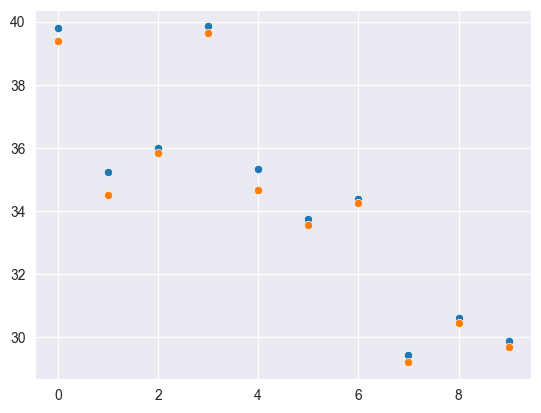

In [78]:
sns.scatterplot(x=np.arange(len(raw)), y=raw)
sns.scatterplot(x=np.arange(len(post_process)), y=post_process)

In [15]:
Xtest1 = X_test[X_test['system_id'] == 17658]
ytest1 = y_test.loc[Xtest1.index]
Xtest1.index = pv[(pv['year'] >= 2020) & (pv['system_id'] == 17658)]['timestamp']
ytest1.index = Xtest1.index

In [16]:
pred1 = mdl.predict(Xtest1)
pred1[pred1 < 0] = 0

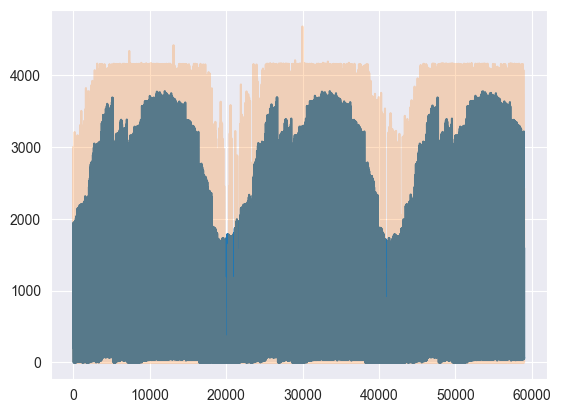

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(pred1)
plt.plot(ytest1.values, alpha=0.25)

In [18]:
#ytest1.reset_index(drop=True, inplace=True)

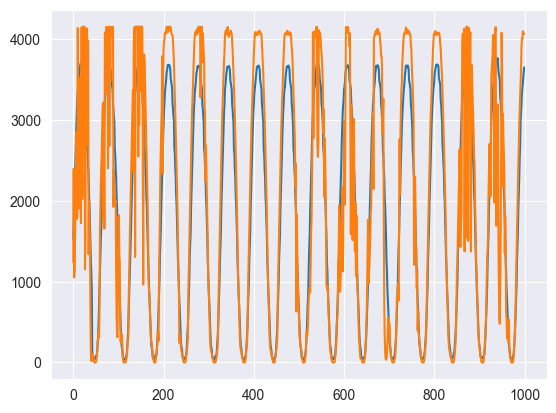

In [61]:
plt.plot(pred1[10000:11000])
plt.plot(ytest1[10000:11000].reset_index(drop=True))

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

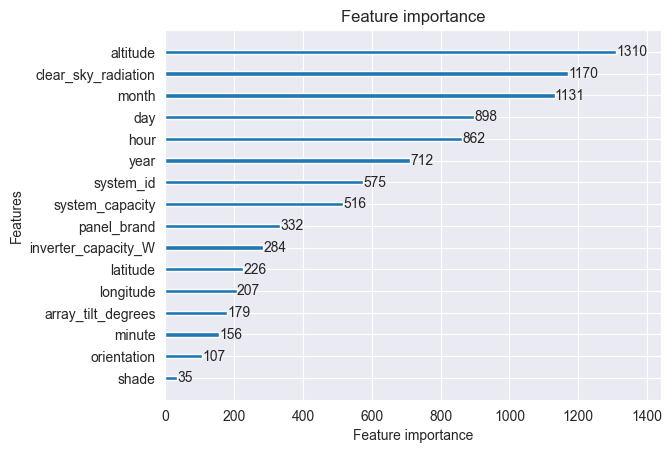

In [79]:
from lightgbm import plot_importance, plot_tree, plot_split_value_histogram
plot_importance(mdl)

# Solar Altitude and Azimuth

In [27]:
from pysolar.solar import *
import datetime
import pytz

local_tz = pytz.timezone('CET')

#date = local_tz.localize(datetime.datetime(2020, 1, 1, 12,1,1))
#metadata['elevation'] = metadata.apply(lambda x: get_altitude(x.latitude, x.longitude, date), axis=1)
#print(get_altitude(latitude, longitude, date))
#pv['altitude'] = pv.apply(lambda x: get_altitude(x.latitude, x.longitude, local_tz.localize(datetime.datetime(x.year, x.month, x.day, x.hour, x.minute))), axis=1)

In [28]:
#azimuth = pv.apply(lambda x: get_azimuth(x.latitude))
pv.head()

,system_id,timestamp,instantaneous_power_W,system_capacity,panel_brand,orientation,array_tilt_degrees,inverter_capacity_W,shade,month,day,hour,minute,year,latitude,longitude,altitude,azimuth,clear_sky_radiation
0,11080,2015-01-01 08:15:00,3.000000,3000,Solsonica Building Integrated,SW,27.0,3000,Low,1,1,8,15,2015,45.020716,7.469484,0.588349,123.743862,0.001584
1,11080,2015-01-01 08:30:00,19.333333,3000,Solsonica Building Integrated,SW,27.0,3000,Low,1,1,8,30,2015,45.020716,7.469484,2.559359,126.427921,54.547129
2,11080,2015-01-01 08:45:00,41.666667,3000,Solsonica Building Integrated,SW,27.0,3000,Low,1,1,8,45,2015,45.020716,7.469484,4.568644,129.174678,214.832955
3,11080,2015-01-01 09:00:00,86.333333,3000,Solsonica Building Integrated,SW,27.0,3000,Low,1,1,9,0,2015,45.020716,7.469484,6.537845,131.989450,363.322521
4,11080,2015-01-01 09:15:00,113.666667,3000,Solsonica Building Integrated,SW,27.0,3000,Low,1,1,9,15,2015,45.020716,7.469484,8.436653,134.876911,477.849767


In [29]:
#pv.to_csv('/Users/carterdemars/Desktop/pv_data/topten.csv')

In [30]:
#get_altitude(36.715, 15.091, datetime(2020,1,1, timezome=))

In [31]:
#pv['azimuth'] = pv.apply(lambda x: get_azimuth(x.latitude, x.longitude, local_tz.localize(datetime.datetime(x.year, x.month, x.day, x.hour, x.minute))), axis=1)

In [32]:
#from pysolar import radiation
#pv['clear_sky_radiation'] = pv.apply(lambda x: radiation.get_radiation_direct(local_tz.localize(datetime.datetime(x.year, x.month, x.day, x.hour, x.minute)), x.altitude), axis=1)

In [87]:
# https://neptune.ai/blog/lightgbm-parameters-guide

import lightgbm as lgb
import optuna

# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values of the hyperparameters using a trial object.
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'num_iterations': trial.suggest_int('num_iterations', 100, 1000),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    }

    mdl = lgb.train(param, dtrain)

    return wmape(y_test, mdl.predict(X_test))

# 3. Create a study object and optimize the objective function.
dtrain = lgb.Dataset(X_train, y_train)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2023-06-19 17:52:50,824] A new study created in memory with name: no-name-0591abc2-0e3d-466b-ad91-e55cae3171eb
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-06-19 17:53:04,677] Trial 0 finished with value: 33.34252066230618 and parameters: {'lambda_l1': 0.38343025405282866, 'lambda_l2': 0.0728473390396229, 'num_leaves': 194, 'num_iterations': 524, 'feature_fraction': 0.41520619790957525, 'bagging_fraction': 0.44931193242253165, 'bagging_freq': 6, 'max_depth': 7, 'learning_rate': 0.04568324098723892}. Best is trial 0 with value: 33.34252066230618.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-06-19 17:53:15,630] Trial 1 finish

KeyboardInterrupt: 

In [34]:
pred = mdl.predict(X_test)

(array([272634., 141515.,  93970.,  47037.,  13439.,  13767.,   4874.,
          5231.,   5756.,   2822.]),
 array([ -336.17830362,   819.54358661,  1975.26547684,  3130.98736707,
         4286.70925731,  5442.43114754,  6598.15303777,  7753.874928  ,
         8909.59681823, 10065.31870847, 11221.0405987 ]),
 <BarContainer object of 10 artists>)

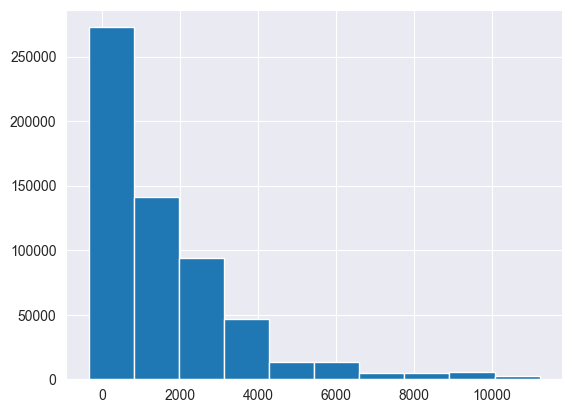

In [35]:
plt.hist(pred)

(array([3.77360e+05, 1.11789e+05, 7.00660e+04, 1.59120e+04, 1.04160e+04,
        5.00200e+03, 6.16500e+03, 3.73900e+03, 5.62000e+02, 3.40000e+01]),
 array([    0.        ,  1542.83333333,  3085.66666667,  4628.5       ,
         6171.33333333,  7714.16666667,  9257.        , 10799.83333333,
        12342.66666667, 13885.5       , 15428.33333333]),
 <BarContainer object of 10 artists>)

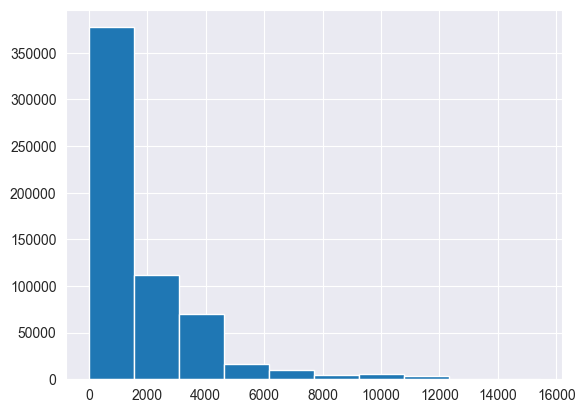

In [36]:
plt.hist(y_test)

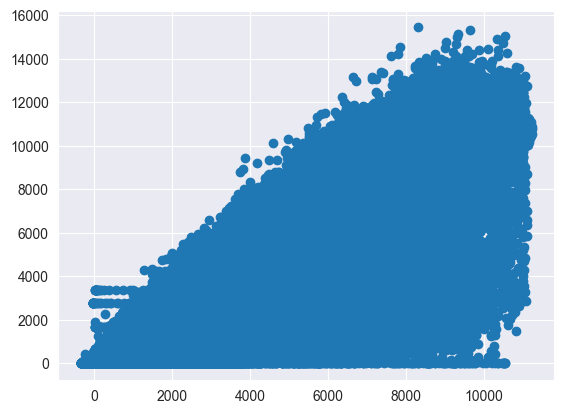

In [37]:
plt.scatter(pred, y_test)

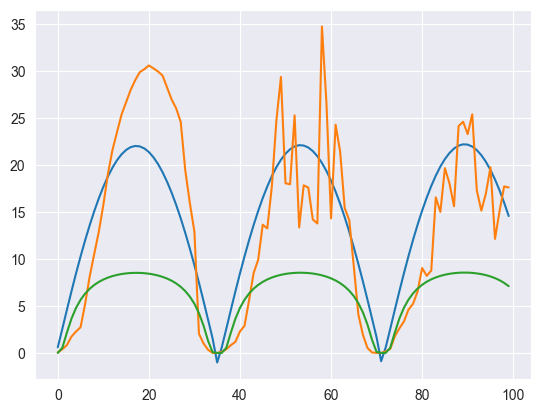

In [38]:
plt.plot(pv['altitude'].head(100))
plt.plot(pv['instantaneous_power_W'].head(100)/50)
plt.plot(pv['clear_sky_radiation'].head(100)/100)

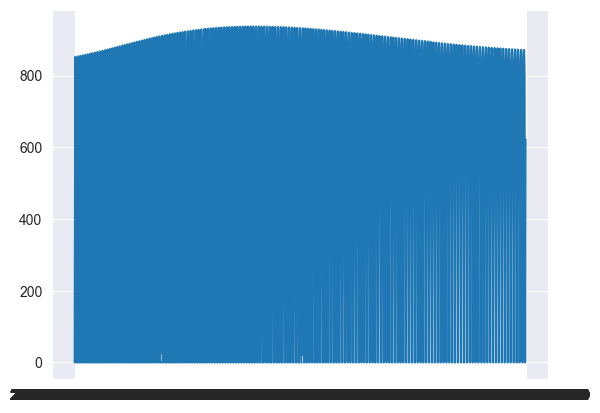

In [40]:
#plt.plot(Xtest1['clear_sky_radiation'].head(10000))

Let's try building an analytical model

In [41]:
site = pv[pv['system_id'] == 11080].dropna()
X = site[['clear_sky_radiation', 'altitude', 'azimuth']]
y = site['instantaneous_power_W']

In [42]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [43]:
lm.fit(X,y)

LinearRegression()

In [44]:
lm.coef_

array([ 0.76643564, 14.39064592,  2.71718336])

In [45]:
pred = lm.predict(X)

In [47]:
mean_absolute_error(pred, y)

368.3001451521026

368.3001451521026

In [48]:
wmape(y, pred)

55.499753987041615

In [ ]:
plt.plot(pred[20000:20200])
plt.plot(y[20000:20200].reset_index(drop=True), alpha=0.25)

In [49]:
from scipy.optimize import curve_fit

In [50]:
myfun = lambda x: np.max(x, 0)

def analytical_fun(X, a, b, c, d):
 """
 :param a: solar irradiance
 :param b: solar altitude
 :param c: azimuth
 :param d: intercept value
 :return:
 """
 #clear_sky = X[:, 0]
 #azimuth = X[:, 1]
 #altitude = X[:, 2]
 res = a*X[:, 0] + b*X[:, 1] + c*X[:, 2] + d
 res = pd.Series(res).apply(lambda x: max(0, x))
 res = np.array(res)
 return res #b*azimuth + c*altitude + d)

In [51]:
# X_line = np.arange(X.clear_sky_radiation.min(), X.clear_sky_radiation.max(), 1)
# y_line = analytical_fun(X_line)

coefs, cov = curve_fit(analytical_fun, X.values.reshape(-1,3), y.tolist())#, p0=[7000, 0.002732, 5000, 0], bounds=[(5000,0.0005, 5000, -60), (10000, 0.2, 8000, 60)])

In [52]:
coefs

array([    2.10422126,    16.87533823,     3.63315065, -1919.40687806])

In [53]:
pred = analytical_fun(X.values.reshape(-1,3), coefs[0], coefs[1], coefs[2], coefs[3])

In [54]:
mean_absolute_error(pred, y)

279.7657697795611

In [ ]:
plt.plot(pred[:1000])
plt.plot(y[:1000], alpha=0.25)

In [ ]:
from utils.model_utils import wmape

In [55]:
wmape(y, pred)

42.15836350091191

In [56]:
mean_absolute_error(y, pred)

279.7657697795611

In [57]:
mean_absolute_percentage_error(y, pred)

5672450553455932.0

In [58]:
y.max()

2974.0

In [59]:
y.min()

0.0

In [60]:
y.mean()

663.6068066861977